# RNN model notebook

In [1]:
!pip install -q gdown

### Importing required libraries

In [2]:
import gdown
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score

## Data donwload

In [3]:
gdown.download("https://drive.google.com/u/0/uc?export=download&confirm=znhq&id=1RHS3GdZNM9yz89GNWYycc3V94ezI3JzC", "request.gz", True)

'request.gz'

In [4]:
!gunzip request.gz

### Data preprocessing

In [5]:
data = pd.read_json("/content/request", lines=True)

In [6]:
data.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,False,"05 1, 2015",A8WEXFRWX1ZHH,0209688726,{'Color:': ' AC'},Goldengate,"After I wrote the below review, the manufactur...",Works well if you place phone in horizontally ...,1430438400,NaN,NaN
1,1,True,"04 19, 2018",ABCA1A8E4DGV1,0209688726,{'Color:': ' Blue'},noe,It sucks barely picks up anything definitely n...,sucks,1524096000,NaN,NaN
2,1,True,"04 16, 2018",A1NX8HM89FRQ32,0209688726,{'Color:': ' Black'},Eduard,"Well to write a short one, it blew 2 fuses of ...",Defective,1523836800,NaN,NaN
3,3,True,"04 13, 2018",A1X77G023NY0KY,0209688726,{'Color:': ' CA'},Lauren,I have absolutely no memory of buying this but...,Looks cool! Probably works,1523577600,NaN,NaN
4,5,True,"04 8, 2018",A3GK37JO2MGW6Q,0209688726,{'Color:': ' Black'},danny,it ok it does it job,Five Stars,1523145600,NaN,NaN


Deleting redundant data columns (

---

I tried to train the model on the "summary" data (and got quite good results - 0.81 f1_score) 
     
BUT! "Summary" does not contain enough information, as comment section does. That's why I am dropping "summary" in the next cells



In [7]:
data = data[["overall", "reviewText"]]

Check for NaN values

In [8]:
data.isna().any()

overall       False
reviewText     True
dtype: bool

In [9]:
print("Amount of samples BEFORE dropping empty values: ", data.shape[0])
print("Amount of samples AFTER dropping empty values: ", data.dropna().shape[0])
print("Amount of dropped lines: ", data.shape[0] - data.dropna().shape[0])

Amount of samples BEFORE dropping empty values:  1000000
Amount of samples AFTER dropping empty values:  999636
Amount of dropped lines:  364


Delete missed values and reset index

In [10]:
data.dropna(inplace=True)

In [11]:
data.reset_index(drop=True, inplace=True)

In [12]:
data.describe()

,overall
count,999636.000000
mean,4.480915
std,1.022296
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [13]:
rate_distr = dict(data.value_counts("overall"))

**As we see, there is disbalance in our data**

[Text(0, 0.5, 'Feedbacks amount'), Text(0.5, 0, 'Rate')]

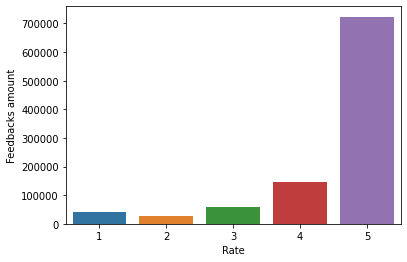

In [14]:
ax = sns.barplot(x = list(rate_distr.keys()), y = list(rate_distr.values()))
ax.set(xlabel="Rate", ylabel="Feedbacks amount")

Check the sentence lengths

In [15]:
reviewsLength = data["reviewText"].apply(lambda x: len(x.split()))

In [16]:
reviewsLength.describe()

count    999636.000000
mean         36.617947
std          58.642644
min           0.000000
25%           6.000000
50%          20.000000
75%          43.000000
max        3727.000000
Name: reviewText, dtype: float64

Decreasing the value by one for training reasons (As I have multi-class classification)

In [17]:
data["overall"] = data["overall"].apply(lambda x: x-1)

### **BPE Tokenizer**

---
I decided to use that tokenizer as it worked well for many Neural networks and "BPE" appears quite offen in different papers.


In [18]:
!pip install -q youtokentome

     |████████████████████████████████| 1.7MB 8.1MB/s 


In [19]:
import youtokentome as yttm

In [20]:
def train_bpe(text_data: pd.Series, vocab_size, train_file_path, model_path):
    with open(train_file_path, "w") as file:
        for row in text_data:
            file.write(row)
    
    yttm.BPE.train(train_file_path, vocab_size=vocab_size, model=model_path)
    return yttm.BPE(model=model_path)

In [21]:
%%time

train_file_path = "bpe_train_data.txt"
model_path = "bpe_model.bin"
text_col_name = "reviewText"

bpe_processor = train_bpe(data[text_col_name], vocab_size=7000, train_file_path=train_file_path, model_path=model_path)

CPU times: user 15.2 s, sys: 1.01 s, total: 16.2 s
Wall time: 9.77 s


In [22]:
vocab = bpe_processor.vocab()

In [23]:
len(vocab)

7000

### Applying tokenization for sentence to check the data with pandas *describe* method. 

---
It allows to check the estimate length of comments and choose the right **max_length** truncation attribute for future data tokenization.

 The reason is that having a lot of zeros in data (as a padding) won't lead to good results.


In [24]:
def tokenize_sentence(sentence):
    sentence = sentence.lower()
    tokens = bpe_processor.encode(sentence, bos=True, eos=True)
    return tokens

data["reviewText"].apply(lambda x: tokenize_sentence(x)).apply(lambda x: len(x)).describe()

count    999636.000000
mean         45.770188
std          73.130578
min           2.000000
25%           9.000000
50%          24.000000
75%          53.000000
max        4706.000000
Name: reviewText, dtype: float64

As we see above, ***75%*** of our comments have up to 56 tokens, so it looks like limiting max_length with values in rage of 60-70  - good idea.

In [25]:
class RateDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe: pd.DataFrame, bpe_processor, vocab, text_col="reviewText", lower=True, max_sen_len=65):
        self.dataframe = dataframe.copy()
        self.max_sen_len = max_sen_len
        self.lower = lower
        self.bpe_processor = bpe_processor
        self.vocab = vocab

        self.dataframe[text_col] = self.dataframe[text_col].apply(lambda x: self.__tokenize_sentence(x))

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        label, comment = self.dataframe.iloc[idx, :]

        return {
            "comment": comment,
            "label": label
        }        

    def __tokenize_sentence(self, sentence):
        sentence = sentence.lower() if self.lower else sentence
        tokens = self.bpe_processor.encode(sentence, bos=True)
        tokens = tokens[:self.max_sen_len - 1] + [self.bpe_processor.subword_to_id(self.vocab[3])]
        tokens += (self.max_sen_len - len(tokens)) * [self.bpe_processor.subword_to_id(self.vocab[0])]
        return tokens

In [26]:
%%time
dataset = RateDataset(data, bpe_processor, vocab)

CPU times: user 28.3 s, sys: 95.4 ms, total: 28.4 s
Wall time: 28.5 s


In [27]:
def split_data(dataset, ratios):
    lengths = [int(len(dataset) * ratio) for ratio in ratios]
    if np.sum(lengths != len(dataset)):
        lengths[-1] = len(dataset) - np.sum(lengths[:-1])

    return random_split(dataset, lengths)

In [28]:
train_dataset, valid_dataset, test_dataset = split_data(dataset, [0.8, 0.1, 0.1])

Defining custom collate_fn function for correct data batching.

In [29]:
def custom_collate_fn(batch):
    comments = [item["comment"] for item in batch]
    labels = [item["label"] for item in batch]

    return {
        "comments": torch.LongTensor(comments),
        "labels": torch.LongTensor(labels)
    }

In [30]:
#@title Batch size setup { run: "auto" }
BATCH_SIZE = 64 #@param ["16", "32", "64", "128"] {type:"raw"}

In [31]:
train_iterator = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn)
valid_iterator   = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn)
test_iterator  = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=custom_collate_fn)

### I decided to try to train an RNN model with LSTM layers.

In [69]:
class Model(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_sizes, output_size, num_layers, dropout, rnn_dropout, bidirectional):
        super().__init__()
        
        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        rnn_hidden_dim = hidden_size // num_directions

        self.embedding_layer = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, rnn_hidden_dim, dropout=rnn_dropout, num_layers=num_layers, 
                           bidirectional=bidirectional, bias=True, batch_first=True)
        self.dropout = dropout

        custom_module_list = []
        if len(hidden_sizes) != 1:
            custom_module_list = [
                    [
                        nn.Linear(hidden_sizes[idx], hidden_sizes[idx+1]),
                        nn.ReLU(),
                        nn.BatchNorm1d(hidden_sizes[idx+1])
                    ]
                    for idx in range(len(hidden_sizes)) if idx < len(hidden_sizes)-1
            ]

        custom_module_list.append([nn.Linear(hidden_sizes[-1], output_size)])

        modules = []
        for module in custom_module_list:
            modules = np.concatenate((modules, module))

        self.fc = nn.Sequential(modules)

    def forward(self, inputs):
        embedded = self.embedding_layer(inputs)
        output, (hidden, cell) = self.rnn(embedded)
        hidden = torch.cat([hidden[-2, :, :], hidden[-1, :, :]], 1)
        hidden = nn.Dropout(self.dropout)(hidden)

        logits = self.fc(hidden)
        return logits

In [79]:
#@title **Model hyperparameters** { run: "auto" }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is: ", device)

VOCAB_SIZE = len(vocab)
OUTPUT_SIZE = 5 #equals to number of label classes 
EMB_SIZE = 300 #@param {type:"slider", min:100, max:1000, step:50}
HIDDEN_SIZES = [1024, 512, 256] #@param ["[256, 128, 64]", "[512, 256, 64]", "[512, 256, 128]", "[1024, 512, 256]", "[2048, 1024, 512]"] {type:"raw"}
RNN_DROPOUT = 0.2 #@param {type:"slider", min:0.1, max:0.9, step:0.1}
DROPOUT = 0.2 #@param {type:"slider", min:0.1, max:0.9, step:0.1}
NUM_LAYERS = 2 #@param {type:"slider", min:1, max:11, step:1}
BIDIRECTIONAL = True #@param {type:"boolean"}



Device is:  cuda


In [ ]:
model = Model(VOCAB_SIZE, EMB_SIZE, HIDDEN_SIZES, OUTPUT_SIZE, NUM_LAYERS, DROPOUT, RNN_DROPOUT, BIDIRECTIONAL)
model.to(device)

In [72]:
def count_parameters(model):
    return np.sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 12,392,741 trainable parameters


Almost at the top of this notebook rate score distribution has been plotted.

To deal with current problem, it's worthy to use "weight" CrossEntropyLoss`s attribute for defining how much attetion to pay for other labels while training.

In [73]:
weighted_tensor = []

for rate_count in data["overall"].value_counts():
    rate_ratio = np.round(1 - rate_count / len(data["overall"]), 1)
    weighted_tensor.append(rate_ratio)

weighted_tensor = torch.FloatTensor(weighted_tensor)
weighted_tensor

tensor([0.3000, 0.9000, 0.9000, 1.0000, 1.0000])

In [74]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(weight=weighted_tensor.to(device))

In [75]:
def train(train_iterator, model, device, optimizer, criterion):
    model.train()

    all_predicts = []
    all_targets = []
    train_loss = 0

    for iteration, batch in tqdm(enumerate(train_iterator), total=len(train_iterator)):
        
        comments = batch["comments"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(comments)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        probs = torch.softmax(outputs, 1)
        preds = torch.argmax(probs, 1)

        all_predicts = np.concatenate((all_predicts, preds.cpu().detach().numpy()))
        all_targets = np.concatenate((all_targets, labels.cpu().detach().numpy()))

        train_loss += loss.item()

    train_loss /= len(train_iterator)

    return train_loss, f1_score(all_targets, all_predicts, average="weighted")

In [76]:
def evaluate(valid_iterator, model, device, criterion):
    model.eval()

    val_loss = 0
    all_predicts = []
    all_targets = []

    for iteration, batch in tqdm(enumerate(valid_iterator), total=len(valid_iterator)):
        comments = batch["comments"].to(device)
        labels = batch["labels"].to(device)

        logits = model(comments)
        loss = criterion(logits, labels)
        8
        probs = torch.softmax(logits, 1)
        preds = torch.argmax(probs, 1)

        all_predicts = np.concatenate((all_predicts, preds.cpu().detach().numpy()))
        all_targets = np.concatenate((all_targets, labels.cpu().detach().numpy()))

        val_loss += loss.item()

    val_loss /= len(valid_iterator)
    
    return val_loss, f1_score(all_targets, all_predicts, average="weighted")

In [77]:
#@title **Train hyperparameters** { run: "auto" }

EPOCHS = 8 #@param {type:"slider", min:1, max:10, step:1}
PATIENCE = 2 #@param {type:"slider", min:1, max:10, step:1}
MIN_LOSS = np.inf

### Training process

In [78]:
CUR_PATIENCE = 0

for epoch in range(EPOCHS):

    train_loss, train_f1 = train(train_iterator, model, device, optimizer, criterion)
    valid_loss, valid_f1 = evaluate(valid_iterator, model, device, criterion)

    print(f'Epoch: {epoch + 1}\n \
           Training Loss: {train_loss}, Training f1_score: {train_f1}\n \
           Validation Loss: {valid_loss}, Validation f1_score: {valid_f1}')

    if valid_loss < MIN_LOSS:
        MIN_LOSS = valid_loss
        best_model = model.state_dict()
    else:
        CUR_PATIENCE += 1
        if CUR_PATIENCE == PATIENCE:
            CUR_PATIENCE = 0
            break

torch.save(best_model, 'rnn_model.pt')


Epoch: 1
            Training Loss: 0.6013735884707541, Training f1_score: 0.7111440276981611
            Validation Loss: 0.5539688359416554, Validation f1_score: 0.7316671588608354



Epoch: 2
            Training Loss: 0.5409110347142922, Training f1_score: 0.7458026184572178
            Validation Loss: 0.5422283749879552, Validation f1_score: 0.7388162747066815



Epoch: 3
            Training Loss: 0.5117008323624979, Training f1_score: 0.7628335873745544
            Validation Loss: 0.5443303096042552, Validation f1_score: 0.7473702586012656



Epoch: 4
            Training Loss: 0.489404339689127, Training f1_score: 0.7753521070835256
            Validation Loss: 0.5496234205120962, Validation f1_score: 0.7501453071907109


In [80]:
model = torch.load("rnn_model.pt")

Best model state_dict at google drive

In [ ]:
gdown.download("https://drive.google.com/u/0/uc?export=download&confirm=tM7b&id=1rvDn1h7ruN-inf8177Enjhzrtjpln7M1", "rnn_model.pt", True)

In [81]:
model = Model(VOCAB_SIZE, EMB_SIZE, hIDDEN_SIZES, OUTPUT_SIZE, NUM_LAYERS, DROPOUT, RNN_DROPOUT, BIDIRECTIONAL)
model.load_state_dict(torch.load("/content/rnn_model.pt"))
model.to(device)

Model(
  (embedding_layer): Embedding(7000, 300)
  (rnn): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=5, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

### Testing

In [82]:
def test(test_iterator, model, device, criterion, update_plot_iter):
    model.eval()

    all_predicts = []
    all_targets = []

    history = []
    
    for iteration, batch in tqdm(enumerate(test_iterator), total=len(test_iterator)):
        comments = batch["comments"].to(device)
        labels = batch["labels"].to(device)

        logits = model(comments)
        loss = criterion(logits, labels)

        probs = torch.softmax(logits, 1)
        preds = torch.argmax(probs, 1)

        all_predicts = np.concatenate((all_predicts, preds.cpu().detach().numpy()))
        all_targets = np.concatenate((all_targets, labels.cpu().detach().numpy()))
        
    print("F1 score: ", f1_score(all_targets, all_predicts, average="weighted"))

In [84]:
test(test_iterator, model, device, criterion, 40)


F1 score:  0.747181432809821


### Predicting

In [85]:
def predict_rate(sentence):
    lower = True
    max_sen_len = len(sentence)

    sentence = sentence.lower() if lower else sentence
    tokens = bpe_processor.encode(sentence, bos=True)
    tokens = tokens[:max_sen_len - 1] + [bpe_processor.subword_to_id(vocab[3])]
    tokens += (max_sen_len - len(tokens)) * [bpe_processor.subword_to_id(vocab[0])]

    model.eval()
    model_input = torch.LongTensor(tokens).unsqueeze(0).to(device)
    logits = model(model_input)
    probs = torch.softmax(logits, 1)
    prediction = torch.argmax(probs, 1)

    return prediction.item() + 1

In [87]:
sentence = "Good product"
predict_rate(sentence)

5

In [86]:
sentence = "I am not satisfied"
predict_rate(sentence)

2

In [88]:
sentence = "Vacuum cleaner sucks!"
predict_rate(sentence)

5

In [90]:
sentence = "Bad quality"
predict_rate(sentence)

1

In [91]:
sentence = "Not bad"
predict_rate(sentence)

4

In [92]:
sentence = "So-so"
predict_rate(sentence)

3